In [1]:
import nppar
import time
import numpy as np
import math
import datatable as dt
import time
import xarray
import os
import fileutils
import traceback
from datetime import datetime
import multiprocessing as mp
import random
from functools import partial
from multiprocessing import Pool, Array, Process, Manager
from functools import partial
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axes_grid1
from multiprocessing import shared_memory

In [2]:
def gridinfo():
    rdiff=2227
    minnorth=333237
    #maxwest=1160624
    minwest=1156167
    maxeast=2747676
    maxsouth=3504175
    gridwidth=((maxeast-minwest) % rdiff) + 1
    firstid = minwest-math.ceil((minwest-minnorth) / rdiff)*rdiff
    gridheight=math.ceil((maxsouth-firstid) / rdiff)
    return rdiff, firstid, gridwidth, gridheight

def walkmonthdays(sfolder):
    #sfolder = '/data2/ffp/datasets/daily/2015/08'
    exfeat = ["id", "firedate"]
    dayfiles=[]
    for dayf in fileutils.find_files(sfolder, '*_norm.csv', listtype="walk"):
        dayfiles+=[dayf]
        #print(fday)
        '''
        try:
            #fday = '/data2/ffp/datasets/daily/2021/08/20210804_norm.csv'
            creategrid_xs(fday, rdiff, firstid, gridwidth, gridheight)
        except:
            print("Fail to convert %s"%fday)
            traceback.print_exc()
        '''
    return dayfiles

def get_grid_xy(firstid, rdiff, _id,):
    row =int((_id-firstid)/rdiff)
    col = int(_id-firstid-rdiff*row)
    return row,col

def assignrow(ggrid, tabrow):
    row, col = get_xy(tabrow[0])
    ggrid[row, col, :]=tabrow[:]

def assignrowshared(ggrid_sh, grid_shape, tabrows):
    for i in range(tabrows.shape[0]):
        tabrow=tabrows[i,:]
        try:
            row, col = get_xy(tabrow[0])
            idx = row*grid_shape[1]*grid_shape[2]+col*grid_shape[2]
            ggrid_sh[idx:idx+grid_shape[2]]=tabrow[:]
        except:
            "Error row: %s\n"%i+traceback.print_exc()
            
def assignrowshared2(ggrid_sh, tabrows):
    for i in range(tabrows.shape[0]):
        tabrow=tabrows[i,:]
        try:
            row, col = get_xy(tabrow[0])
            ggrid_sh[row, col]=tabrow[:]
            #print(row, col)
        except:
            "Error row: %s\n"%i+traceback.print_exc()

In [3]:
def plotspeedup(wspeedup,pspeedup,ncpus):
    plt.plot(range(1,ncpus+1), wspeedup, label = "wall speed-up")
    plt.plot(range(1,ncpus+1), pspeedup, label = "speed-up per CPU")
    plt.plot(range(1,ncpus+1), range(1,ncpus+1), label = "Ideal speed-up")
    plt.xlabel("Number of CPUs")
    plt.ylabel("Speed-up")
    plt.grid(visible=True, axis='y')
    plt.legend()
    plt.show()

In [41]:
def plotwall(wall,ncpus, ytitle="Time (sec)", yscale="linear"):
    plt.figure(figsize=(10,6))
    for wallline in wall: 
        plt.plot(range(1,ncpus+1), wall[wallline], label = wallline)
    plt.yscale(yscale)
    plt.xlabel("Number of CPUs")
    plt.ylabel(ytitle)
    plt.grid(visible=True, axis='y')
    plt.legend()
    plt.show()

In [5]:
#initialize
rdiff, firstid, gridwidth, gridheight = gridinfo()
get_xy=partial(get_grid_xy, firstid, rdiff)
dayfiles=walkmonthdays('/data2/ffp/datasets/daily/')
fday='/data2/ffp/datasets/daily/2021/08/20210823_norm.csv'
dt_df = dt.fread(fday)
firstfeat=dt_df.names.index('id')
npday = dt_df[:, firstfeat:].to_numpy(dt.float32)
maxcpus=mp.cpu_count()
featn = len(dt_df[:, firstfeat:].names)
ggrid = np.zeros((gridwidth, gridheight, featn))
ggrid[:,:]=np.nan
assignr=partial(assignrow, ggrid)
print('max cpu count %s'%maxcpus)
print('array rows: %s'%npday.shape[0])

max cpu count 16
array rows: 372918


### Simple python run

In [15]:
nruns=1
totalrun=0
start = time.time()
for i in range(npday.shape[0]):
    assignr(npday[i])
end = time.time()
print('time: %.2f sec'%(end-start))
pythonsimple=[end-start]*maxcpus

time: 3.08 sec


In [18]:
allwall={}
allwall['Simple Python Loop']=pythonsimple

### Multiprocessing with map

In [57]:
nruns=1
npdayl=list(npday)
multimap=[]
for cpus in range(1,maxcpus+1):
    totalrun=0
    for run in range(nruns):
        start = time.time()
        with Pool(cpus) as p:
            p.map(assignr, npdayl)
        end = time.time()
        totalrun+=(end - start)
    print('average time: %.2f sec, cpus: %s'%(totalrun/nruns, cpus))
    multimap+=[totalrun/nruns]
npdayl=None


average time: 37.51 sec, cpus: 1
average time: 38.76 sec, cpus: 2
average time: 57.94 sec, cpus: 3
average time: 75.03 sec, cpus: 4


Process ForkPoolWorker-449:
Process ForkPoolWorker-452:
Process ForkPoolWorker-451:
Process ForkPoolWorker-450:
Traceback (most recent call last):
Process ForkPoolWorker-448:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


UnpicklingError: invalid load key, '\x00'.

  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/multiprocessing/pool.py", li

In [17]:
allwall['Multiprocessing with map']=multimap

NameError: name 'multimap' is not defined

### multiprocessing with shared memory

In [30]:
nruns=1
totalrun=0
ncpus=maxcpus
multishared=[]
for ncpus in range(1,maxcpus+1):
    start = time.time()
    procs=[]
    chunk = int(npday.shape[0] / ncpus)
    chunk_rem = npday.shape[0] % ncpus
    shm = shared_memory.SharedMemory(create=True, size=4*gridheight*gridwidth*featn)
    shDay = np.ndarray((gridheight, gridwidth, featn), dtype=np.float32, buffer=shm.buf)
    for cpu in range(ncpus-1):
        procs += [Process(target=assignrowshared2, args=(shDay, npday[cpu*chunk:(cpu+1)*chunk]))]
        procs[cpu].start()
    procs += [Process(target=assignrowshared2, args=(shDay, npday[(ncpus-1)*chunk:]))]
    procs[-1].start()
    for p in procs: p.join()
    #print(shDay[75,804])
    shm.close()
    shm.unlink()
    shDay=None
    end = time.time()
    print('time: %.2f sec, cpu: %s'%((end-start),ncpus))
    multishared+=[end-start]


time: 3.45 sec, cpu: 1
time: 1.98 sec, cpu: 2
time: 1.44 sec, cpu: 3
time: 1.28 sec, cpu: 4
time: 1.15 sec, cpu: 5
time: 1.17 sec, cpu: 6
time: 1.13 sec, cpu: 7
time: 1.16 sec, cpu: 8
time: 1.20 sec, cpu: 9
time: 1.22 sec, cpu: 10
time: 1.26 sec, cpu: 11
time: 1.31 sec, cpu: 12
time: 1.39 sec, cpu: 13
time: 1.62 sec, cpu: 14
time: 1.43 sec, cpu: 15
time: 1.50 sec, cpu: 16


In [24]:
allwall['Multiprocessing with shared']=multishared

### cython (with shared memory) cpu 

cpu changes, runs per experiment: 5
average time wall: 0.63 sec, average time CPU: 0.63 sec, threads: 1
average time wall: 0.50 sec, average time CPU: 0.37 sec, threads: 2
average time wall: 0.39 sec, average time CPU: 0.25 sec, threads: 3
average time wall: 0.32 sec, average time CPU: 0.18 sec, threads: 4
average time wall: 0.30 sec, average time CPU: 0.14 sec, threads: 5
average time wall: 0.33 sec, average time CPU: 0.16 sec, threads: 6
average time wall: 0.31 sec, average time CPU: 0.14 sec, threads: 7
average time wall: 0.33 sec, average time CPU: 0.16 sec, threads: 8
average time wall: 0.34 sec, average time CPU: 0.16 sec, threads: 9
average time wall: 0.33 sec, average time CPU: 0.17 sec, threads: 10
average time wall: 0.27 sec, average time CPU: 0.11 sec, threads: 11
average time wall: 0.32 sec, average time CPU: 0.13 sec, threads: 12
average time wall: 0.34 sec, average time CPU: 0.17 sec, threads: 13
average time wall: 0.34 sec, average time CPU: 0.17 sec, threads: 14
average

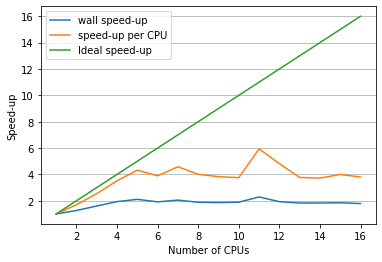

In [21]:
nruns=5
print('cpu changes, runs per experiment: %s'%nruns)
proctimes=[]
speedtimes=[]
walltimes=[]
Tseq=0
for nt in range(1,maxcpus+1):
    proctotal = 0
    walltotal = 0
    for run in range(nruns):
        start = time.time()
        stpr = time.process_time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid, rdiff, gridwidth, gridheight,intensive=0)
        end = time.time()
        endpr = time.process_time()
        proctotal+=(endpr - stpr)
        walltotal+=(end - start)
        avgtw = walltotal/nruns
        avgtp = proctotal/nruns/nt
        if nt==1: 
            Tseqp=avgtp
            Tseqw=avgtw
    print('average time wall: %.2f sec, average time CPU: %.2f sec, threads: %s'%(avgtw, avgtp,nt))
    proctimes+=[Tseqp/avgtp]
    speedtimes+=[Tseqw/avgtw]
    walltimes+=[avgtw]
# plot
plotspeedup(speedtimes, proctimes, maxcpus)

In [22]:
allwall['Cython parallelization with OpenMP']=walltimes

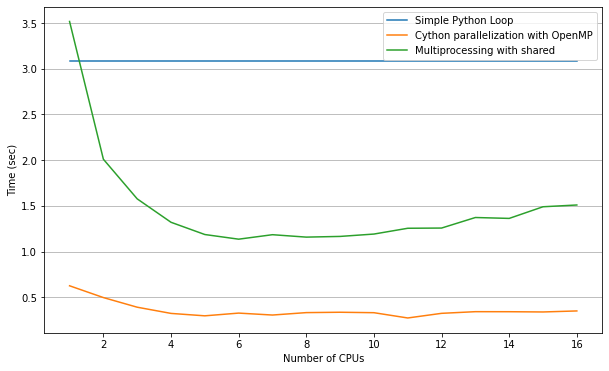

In [44]:
plotwall(allwall,maxcpus)

In [45]:
wallsp={}
wallsp['Simple Python Loop']=[1]*maxcpus
wallsp['Cython parallelization with OpenMP']=[allwall['Simple Python Loop'][0]/t for t in allwall['Cython parallelization with OpenMP']]
wallsp['Multiprocessing with shared']=[allwall['Simple Python Loop'][0]/t for t in allwall['Multiprocessing with shared']]


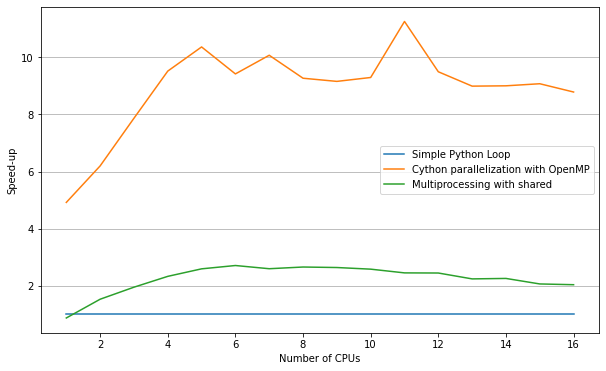

In [46]:
plotwall(wallsp,maxcpus,"Speed-up")

### cython (with shared memory) chunks 

In [13]:
print('chunk changes')
nt = 10
print('rows / threads: %.0f threads: %s' % ((npday.shape[0] / nt),nt))
nruns=20
for cs in range(1,400000,10000):
    totalrun = 0
    for run in range(nruns):
        start = time.time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, 'static', cs)
        end = time.time()
        totalrun+=(end - start)
        avgt = totalrun/nruns
        if nt==1: Tseq=avgt
    print('average time: %.2f chunk: %s'%(totalrun/nruns, cs))

chunk changes
rows / threads: 37292 threads: 10
time: 0.32 chunk: 1
time: 0.28 chunk: 10001
time: 0.28 chunk: 20001
time: 0.29 chunk: 30001
time: 0.26 chunk: 40001
time: 0.27 chunk: 50001
time: 0.28 chunk: 60001
time: 0.29 chunk: 70001
time: 0.31 chunk: 80001
time: 0.32 chunk: 90001
time: 0.33 chunk: 100001
time: 0.34 chunk: 110001
time: 0.36 chunk: 120001
time: 0.37 chunk: 130001
time: 0.38 chunk: 140001
time: 0.39 chunk: 150001
time: 0.40 chunk: 160001
time: 0.41 chunk: 170001
time: 0.43 chunk: 180001
time: 0.43 chunk: 190001
time: 0.44 chunk: 200001
time: 0.45 chunk: 210001
time: 0.46 chunk: 220001
time: 0.48 chunk: 230001
time: 0.49 chunk: 240001
time: 0.50 chunk: 250001
time: 0.51 chunk: 260001
time: 0.52 chunk: 270001
time: 0.53 chunk: 280001
time: 0.54 chunk: 290001
time: 0.54 chunk: 300001
time: 0.58 chunk: 310001
time: 0.58 chunk: 320001
time: 0.58 chunk: 330001
time: 0.58 chunk: 340001
time: 0.59 chunk: 350001
time: 0.61 chunk: 360001
time: 0.62 chunk: 370001
time: 0.63 chunk

### cython (with shared memory) OpenMP schedules

In [ ]:
nt = 14
nruns=30
print('optimum rows / threads: %.0f, threads: %s, runs per experiment: %s' % ((npday.shape[0] / nt),nt, nruns))
for i in range(3):
    id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, None)
schedules = [None, 'static', 'dynamic', 'guided']
random.shuffle(schedules)
for schedule in schedules:
    totalrun = 0
    for run in range(nruns):
        start = time.time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, schedule)
        end = time.time()
        totalrun+=(end - start)
    print('average time: %.2f sec, schedule: %s'%(totalrun/nruns, schedule))

#xaday=xarray.DataArray(data=grid, dims=["x", "y", "feature"],  coords=dict(x=range(gridwidth), y=range(gridheight), feature=range(len(dt_df.names)-1)))



### Table Conversion plus IO read/write (csv to netcdf)

In [5]:
def creategrid_xs_small(rdiff, firstid, gridwidth, gridheight, dayfile, pcpus, ccpus, queue):
    # fday = '/data2/ffp/datasets/daily/2021/08/20210803_norm.csv'
    #print("processing day %s" % dayfile)
    try:
        stpr = time.process_time()
        orig_path = os.path.dirname(dayfile)
        fname = os.path.basename(dayfile)
        daygrid = "%s_grid.nc" % (fname[0:8])
        #if os.path.isfile(os.path.join(orig_path, daygrid)): return
        dt_df = dt.fread(dayfile, nthreads=1)#pcpus)
        firstfeat = dt_df.names.index('id')
        #npday = dt_df[:, firstfeat:].to_numpy(dt.float32)

        dynamic_feat=['id', 'max_temp', 'min_temp', 'mean_temp', 'res_max',
         'dom_vel', 'rain_7days', #'dem', 'slope', 'curvature', 'aspect',
         'ndvi_new', 'evi', 'lst_day', 'lst_night', 'max_dew_temp',
         'mean_dew_temp', 'min_dew_temp', 'fire', 'dir_max_1', 'dir_max_2',
         'dir_max_3', 'dir_max_4', 'dir_max_5', 'dir_max_6', 'dir_max_7',
         'dir_max_8', 'dom_dir_1', 'dom_dir_2', 'dom_dir_3', 'dom_dir_4',
         'dom_dir_5', 'dom_dir_6', 'dom_dir_7', 'dom_dir_8', #'corine_111',
        # 'corine_112', 'corine_121', 'corine_122', 'corine_123', 'corine_124',
        # 'corine_131', 'corine_132', 'corine_133', 'corine_141', 'corine_142',
        # 'corine_211', 'corine_212', 'corine_213', 'corine_221', 'corine_222',
        # 'corine_223', 'corine_231', 'corine_241', 'corine_242', 'corine_243',
        # 'corine_244', 'corine_311', 'corine_312', 'corine_313', 'corine_321',
        # 'corine_322', 'corine_323', 'corine_324', 'corine_331', 'corine_332',
        # 'corine_333', 'corine_334', 'corine_411', 'corine_412', 'corine_421',
        # 'corine_422', 'corine_511', 'corine_512', 'corine_521', 'wkd_0',
        # 'wkd_1', 'wkd_2', 'wkd_3', 'wkd_4', 'wkd_5', 'wkd_6', 'month_7',
        # 'month_4', 'month_5', 'month_6', 'month_8', 'month_9',
        'frequency','f81',]# 'xpos', 'ypos']

        dyn_df = dt_df[:, dynamic_feat]
        npday = dyn_df.to_numpy(dt.float32)
        #print("To cython")

        # start = time.time()
        id2xy, grid = nppar.fillcube(ccpus, npday, firstid, rdiff, gridwidth, gridheight)
        # end = time.time()
        # print(end - start)

        vardict = {}
        for i in range(0, len(dyn_df.names)):
            varname = dyn_df.names[i]
            if dyn_df.names[i] == 'x' or dyn_df.names[i] == 'y':
                varname = '%spos' % varname
            vardict[varname] = (["x", "y", "time"], np.expand_dims(grid[:, :, i], axis=2))

        t = datetime.strptime(os.path.basename(dayfile)[0:8], '%Y%m%d')
        xsday = xarray.Dataset(data_vars=vardict, coords=dict(x=range(gridwidth), y=range(gridheight), time=[t]))
        #print("To disk")
        xsday.to_netcdf(os.path.join(orig_path, daygrid))
        #print("Successfull convertion %s" % dayfile)
        epr = time.process_time()
        queue.put(epr-stpr)
    except:
        print("Fail to convert %s" % dayfile)
        traceback.print_exc()
        with open("/data2/ffp/datasets/daily/failedgrids.log", "a") as f:
            f.write(dayfile)

def new_process(proclist, day, pthreads, cthreads):
    q=mp.Queue()
    proclist += [{'proc':Process(target=creategrid, args=(day, pthreads, cthreads, q)), 'queue': q}]
    proclist[-1]['proc'].start()

def create_xs_files(creategrid, days, pthreads, cthreads):
    procs=[]
    proctimetotal=0
    dayscompleted=[]
    for cpu in range(pthreads):
        d=days.pop()
        dayscompleted+=[d]
        #print('initial proc')
        new_process(procs, d, pthreads, cthreads)
    while len(procs)>0:
        time.sleep(0.1)
        for p in procs:
            try:
                proctimetotal+=p['queue'].get_nowait()
            except:
                pass
            if not p['proc'].is_alive():
                #print('remove, tot procs: %d'%len(procs))
                procs.remove(p)
                #print('tot procs: %d'%len(procs))
        while len(procs)<pthreads:
            if len(days)==0: break
            #print('new proc')
            d = days.pop()
            dayscompleted += [d]
            new_process(procs, d, pthreads, cthreads)
    return proctimetotal

def plotscatter(atimes, typ=0):
    for y in range(1,atimes.shape[1]):
        plt.scatter(range(1,atimes.shape[0]), [y]*(atimes.shape[0]-1), s=atimes[1:, y, typ])
    plt.show()

def plotheatmap(atimes, title1='Wall time', title2='Process (CPU) time'):
    fig = plt.figure(figsize=(12, 6))
    grid = axes_grid1.AxesGrid(
        fig, 111, nrows_ncols=(1, 2), axes_pad = 0.5, cbar_location = "right",
        cbar_mode="each", cbar_size="7%", cbar_pad="5%",)
    data=atimes[1:,1:,0]
    im0 = grid[0].imshow(data, cmap='turbo', interpolation='None')
    grid.cbar_axes[0].colorbar(im0)
    # Show all ticks and label them with the respective list entries
    grid[0].set_xticks(np.arange(data.shape[1]), labels=np.arange(1,data.shape[1]+1))
    grid[0].set_yticks(np.arange(data.shape[0]), labels=np.arange(1,data.shape[0]+1))
    grid[0].set_ylabel('# cython threads')
    grid[0].set_xlabel('# python threads')
    grid[0].title.set_text(title1)
    #ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    if not title2 is None:
        data=atimes[1:,1:,1]
        im1 = grid[1].imshow(data, cmap='turbo', interpolation='None')
        grid[1].set_xticks(np.arange(data.shape[1]), labels=np.arange(1,data.shape[1]+1))
        grid[1].set_xlabel('# python threads')
        grid[1].title.set_text(title2)
        grid.cbar_axes[1].colorbar(im1)
    

In [17]:
creategrid = partial(creategrid_xs_small, rdiff, firstid, gridwidth, gridheight)
nruns=1
totalrun=0
ctr=range(1,17,1)
ptr=range(1,11,1)
atimes=np.zeros((max(list(ctr))+1,max(list(ptr))+1,2))
for cthreads in ctr:
    for pthreads in ptr:
        start=time.time()
        proctime=create_xs_files(creategrid, dayfiles[:10], pthreads, cthreads)
        end=time.time()
        print('wall time: %.1f sec, process time: %.1f sec, python threads %s, cython threads %s' % (end - start, proctime, pthreads, cthreads))
        atimes[cthreads, pthreads,:]=np.array([end-start,proctime])[:]
np.save('tab2convtimes',atimes)        

wall time: 52.0 sec, process time: 37.2 sec, python threads 1, cython threads 1
wall time: 26.9 sec, process time: 46.4 sec, python threads 2, cython threads 1
wall time: 27.8 sec, process time: 55.4 sec, python threads 3, cython threads 1


KeyboardInterrupt: 

Fail to convert /data2/ffp/datasets/daily/2015/09/20150912_norm.csv


Traceback (most recent call last):
  File "<ipython-input-16-a6fb69d03979>", line 52, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150908_norm.csv


Traceback (most recent call last):
  File "<ipython-input-16-a6fb69d03979>", line 52, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150905_norm.csv


Traceback (most recent call last):
  File "<ipython-input-16-a6fb69d03979>", line 52, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150925_norm.csv


Traceback (most recent call last):
  File "<ipython-input-16-a6fb69d03979>", line 52, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


In [108]:
np.save('tab2convtimes',atimes)

In [170]:
atimes=np.load('tab2convtimes.npy')

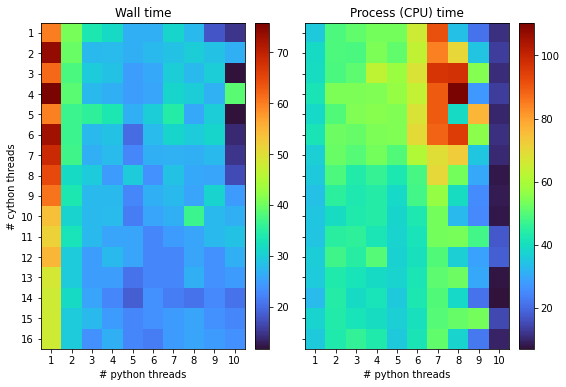

In [171]:
plotheatmap(atimes)

In [86]:
ctr=range(1,17,1)
ptr=range(1,17,1)

In [7]:
creategrid = partial(creategrid_xs_small, rdiff, firstid, gridwidth, gridheight)
nruns=1
totalrun=0
ctr=range(1,17,1)
ptr=range(1,17,1)
atimes2=np.zeros((max(list(ctr))+1,max(list(ptr))+1,2))
for cthreads in ctr:
    for pthreads in ptr:
        start=time.time()
        nfiles=pthreads
        proctime=create_xs_files(creategrid, dayfiles[:nfiles], pthreads, cthreads)
        end=time.time()
        print('wall time: %.1f sec, process time: %.1f sec, python threads %s, cython threads %s' % (end - start, proctime, pthreads, cthreads))
        atimes2[cthreads, pthreads,:]=np.array([end-start,proctime])[:]
np.save('conv_thread_eq_files_02',atimes2)        

wall time: 8.4 sec, process time: 6.6 sec, python threads 1, cython threads 1
wall time: 7.6 sec, process time: 7.2 sec, python threads 2, cython threads 1
wall time: 10.7 sec, process time: 22.5 sec, python threads 3, cython threads 1
wall time: 17.1 sec, process time: 29.8 sec, python threads 4, cython threads 1
wall time: 18.8 sec, process time: 41.5 sec, python threads 5, cython threads 1
wall time: 19.5 sec, process time: 54.5 sec, python threads 6, cython threads 1
wall time: 20.4 sec, process time: 70.5 sec, python threads 7, cython threads 1
wall time: 25.1 sec, process time: 94.4 sec, python threads 8, cython threads 1
wall time: 28.7 sec, process time: 114.0 sec, python threads 9, cython threads 1
wall time: 27.8 sec, process time: 137.1 sec, python threads 10, cython threads 1
wall time: 29.5 sec, process time: 179.6 sec, python threads 11, cython threads 1
wall time: 36.8 sec, process time: 206.6 sec, python threads 12, cython threads 1
wall time: 44.5 sec, process time: 22

wall time: 19.4 sec, process time: 63.9 sec, python threads 7, cython threads 7
wall time: 24.3 sec, process time: 77.9 sec, python threads 8, cython threads 7
wall time: 27.0 sec, process time: 92.8 sec, python threads 9, cython threads 7
wall time: 28.1 sec, process time: 107.9 sec, python threads 10, cython threads 7
wall time: 29.2 sec, process time: 119.7 sec, python threads 11, cython threads 7
wall time: 33.3 sec, process time: 148.0 sec, python threads 12, cython threads 7
wall time: 34.4 sec, process time: 153.2 sec, python threads 13, cython threads 7
wall time: 39.2 sec, process time: 161.0 sec, python threads 14, cython threads 7
wall time: 40.2 sec, process time: 200.6 sec, python threads 15, cython threads 7
wall time: 43.7 sec, process time: 216.1 sec, python threads 16, cython threads 7
wall time: 5.8 sec, process time: 4.1 sec, python threads 1, cython threads 8
wall time: 8.7 sec, process time: 13.8 sec, python threads 2, cython threads 8
wall time: 12.4 sec, process 

wall time: 29.9 sec, process time: 133.9 sec, python threads 12, cython threads 13
wall time: 33.3 sec, process time: 140.2 sec, python threads 13, cython threads 13
wall time: 38.2 sec, process time: 163.9 sec, python threads 14, cython threads 13
wall time: 37.2 sec, process time: 164.2 sec, python threads 15, cython threads 13
wall time: 41.2 sec, process time: 200.0 sec, python threads 16, cython threads 13
wall time: 6.2 sec, process time: 5.2 sec, python threads 1, cython threads 14
wall time: 8.5 sec, process time: 9.5 sec, python threads 2, cython threads 14
wall time: 10.6 sec, process time: 20.7 sec, python threads 3, cython threads 14
wall time: 12.3 sec, process time: 28.5 sec, python threads 4, cython threads 14
wall time: 15.2 sec, process time: 39.6 sec, python threads 5, cython threads 14
wall time: 17.1 sec, process time: 51.1 sec, python threads 6, cython threads 14
wall time: 19.0 sec, process time: 62.4 sec, python threads 7, cython threads 14
wall time: 27.4 sec, p

In [163]:
atimes2=np.load('tab2convtimes2.npy')
#atimes2=np.load('conv_thread_eq_files_01.npy')

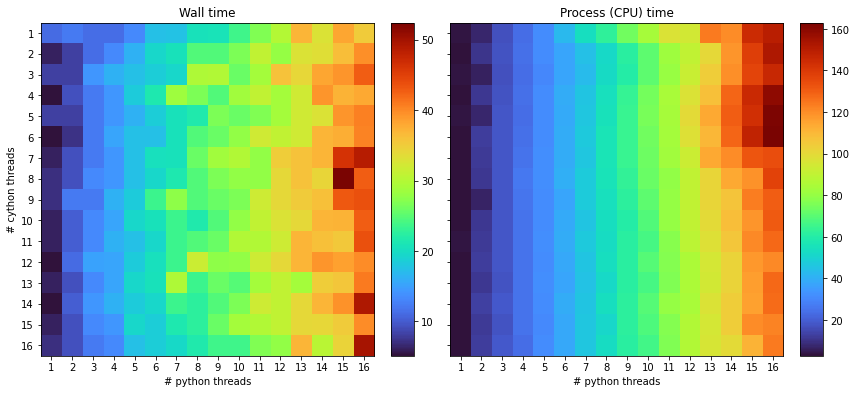

In [164]:
plotheatmap(atimes2)

In [165]:
atimes3=atimes2.copy()
for p in ptr: atimes3[:,p]=atimes2[:,p]/p

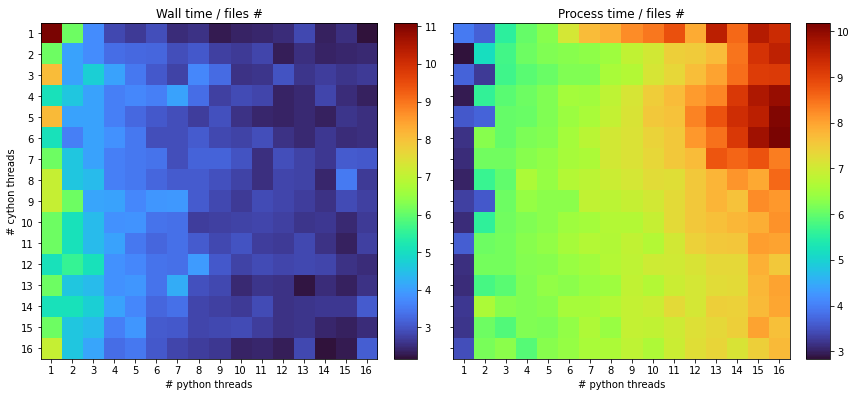

In [166]:
plotheatmap(atimes3,'Wall time / files #', 'Process time / files #')

In [167]:
atimes2=np.load('tab2convtimes2.npy')
#atimes2=np.load('conv_thread_eq_files_01.npy')

In [168]:
atimes4=atimes2.copy()

for j in ptr:
    atimes4[1:,j,0]=(atimes2[1,1,0]*j/atimes2[1:,j,0])
    atimes4[1:,j,1]=atimes2[1:,j,1]/j

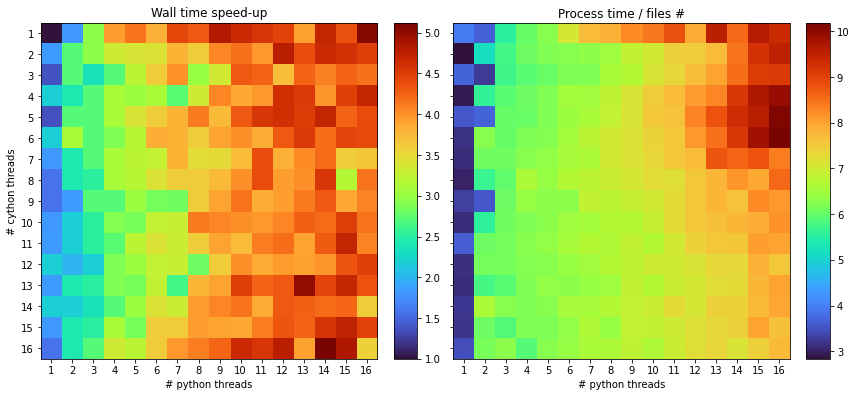

In [169]:
plotheatmap(atimes4, 'Wall time speed-up', 'Process time / files #')

In [192]:
bestthres=0.9

In [193]:
w=np.where(atimes4[:,:,0]>bestthres*atimes4[:,:,0].max())
w

(array([ 1,  1,  1,  1,  2,  2,  4,  5,  5, 11, 13, 13, 15, 16, 16, 16, 16]),
 array([ 9, 10, 14, 16, 12, 14, 16, 12, 14, 15, 13, 15, 15, 10, 12, 14, 15]))

In [194]:
best095=atimes4[atimes4[:,:,0]>bestthres*atimes4[:,:,0].max()]
best095

array([[4.82584363, 8.21780804],
       [4.67121912, 8.41714974],
       [4.70735042, 8.56270718],
       [5.04349423, 9.34403663],
       [4.7763377 , 7.50438112],
       [4.66976611, 8.43960477],
       [4.6899557 , 9.91555258],
       [4.61507721, 8.29928797],
       [4.70454841, 9.31969371],
       [4.70553829, 8.04736979],
       [4.98699502, 7.25486561],
       [4.69305044, 7.77098529],
       [4.72930264, 7.99719829],
       [4.6701357 , 6.637085  ],
       [4.78272413, 7.21041537],
       [5.12285337, 7.12599365],
       [4.84589984, 7.43368513]])

In [195]:
best095min_idx=np.argmin(best095[:,1])
best095min_idx

13

In [196]:
atimes4[w[0][best095min_idx], w[1][best095min_idx]]

array([4.6701357, 6.637085 ])

In [197]:
w[0][best095min_idx], w[1][best095min_idx]

(16, 10)